In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import seaborn as sns
from sklearn import linear_model
import sklearn as sk
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
import statsmodels as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats as ss
from scipy import stats
import scipy.io as sio
from statsmodels import robust
%matplotlib inline

In [2]:
#pip install statsmodels

In [3]:
#get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Data Quality Check

## Demographics

In [4]:
demographics = pd.read_csv('data_exp_6138-v39_questionnaire-zk38.csv', sep = ",")
#demographics.head(15)
# we asked them 7 questions in total

In [5]:
demographics = demographics[demographics['Question Key'] != 'BEGIN QUESTIONNAIRE']
demographics = demographics[demographics['Question Key'] != 'END QUESTIONNAIRE']
demographics['id'] = demographics['Participant Private ID']
demographics['question'] = demographics['Question Key']
demographics['response'] = demographics['Response']
demographics = demographics[['id', 'question', 'response']]

In [6]:
d = pd.pivot_table(demographics, index = 'id', columns = 'question', values = 'response', aggfunc='first')
d = d.reset_index()
d.columns= ['id','age', 'confirmation_1', 'confirmation_2', 'gender', 'gender_numeric','handedness', 'handedness_numeric', 'degree', 'degree_numeric']


In [7]:
d['age'].astype(float).mean()

37.76

In [8]:
d['age'].astype(float).std()

11.00148750273013

In [9]:
d.groupby('gender').nunique()

,id,age,confirmation_1,confirmation_2,gender,gender_numeric,handedness,handedness_numeric,degree,degree_numeric
gender,,,,,,,,,,
Female,48,25,1,1,1,1,2,2,4,4
Male,52,29,1,1,1,1,3,3,3,3


In [10]:
d.to_csv('demographics_100.csv', sep = ',', encoding='utf-8')

## Sound Check

In [11]:
# do a quick check for sound
sound = pd.read_csv('data_exp_6138-v39_task-jgum.csv', sep = ",")
sound = sound.replace('null', np.nan)
sound = sound.replace('nan', np.nan)

In [12]:
sound = sound[np.isfinite(sound['button pressed'])]

In [13]:
correct = [1, 0, 0]* 100

In [14]:
s = (sound['button pressed'] == correct).reset_index(name = 'check')
sound = sound.reset_index()
sound = pd.merge(s[['index', 'check']], sound, on = 'index')
sound_final= sound[['Participant Private ID','button pressed','check']]

In [15]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', None)
#sound_final.head(300)

## rod fixing count

In [16]:
#import csv
#2jau and 5e3j are low-high and high-low
df1 = pd.read_csv('data_exp_6138-v39_task-2jau.csv', sep = ",") # high to low
df2 = pd.read_csv('data_exp_6138-v39_task-5e3j.csv', sep = ",") # low to high

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
#get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#replace all null and nan to the np.nan
df1 = df1.replace('null', np.nan)
df1 = df1.replace('nan', np.nan)
df2 = df2.replace('null', np.nan)
df2 = df2.replace('nan', np.nan)

#turn object into floats and round them and rename them
df1['end_time'] = round(df1['end_time'].astype(float))
df1['start_time'] = round(df1['start_time'].astype(float))
df1['builtin_rt'] = df1['builtin rt'].astype(float) #dont round up builtin reaction time
df1['quality_check'] = df1['rod fixing checked'].astype(float)
df1['id'] = df1['Participant Private ID']
df1['function_id'] = df1['function id']
df1['round_instance'] = df1['round instance']
df1['trial_index'] = df1['index']
df1['key_pressed'] = df1['key pressed']
df1['external_id'] = df1['Participant Public ID']
df1['date'] = df1['UTC Date']

df2['end_time'] = round(df2['end_time'].astype(float))
df2['start_time'] = round(df2['start_time'].astype(float))
#df2['builtin_rt'] = df2['builtin rt'].astype(float) #dont round up builtin reaction time
df2['quality_check'] = df2['rod fixing checked'].astype(float)
df2['id'] = df2['Participant Private ID']
df2['round_instance'] = df2['round_instance']
df2['function_id'] = df2['function id']
df2['trial_index'] = df2['index']
df2['key_pressed'] = df2['key pressed']
df2['external_id'] = df2['Participant Public ID']
df2['date'] = df1['UTC Date']

In [18]:
#select columns from df1 and df2
data1 = df1[['external_id', 'trial_index','id','price_displayed', 'key pressed','environment', 'order', 
           'round_instance', 'task', 'function_id', 'quality_check', 
           'builtin_rt', 'end_time', 'start_time', 'Participant Public ID', 'key_pressed', 'date']]
data2 = df2[['external_id', 'trial_index','id','price_displayed', 'key pressed','environment', 'order', 
           'round_instance', 'task', 'function_id', 'quality_check', 
           'builtin_rt', 'end_time', 'start_time', 'Participant Public ID', 'key_pressed', 'date']]

In [19]:
data1['order'] = ['high-low']*len(data1)
data2['order'] = ['low-high']*len(data2)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
data = pd.concat([data1, data2])
data.index.nunique()
index_manual = list(range(0, len(data)))
data['index'] = index_manual
data = data.set_index('index')
data = data[data.function_id != 'caller']
data = data[pd.notnull(data['function_id'])]



In [21]:
data_useful = data[(data.function_id == "rod_fixing")|(data.function_id == "fishing_l")|(data.function_id == "fishing_h")]
data_useful = data_useful.sort_values(by = ['id', 'start_time'])


In [22]:
data_useful['trial_label'] = data_useful[['trial_index', 'round_instance']].apply(lambda x: ' '.join(x.astype(str)), axis=1)


In [23]:
d = data_useful.groupby(['id', 'trial_label'])['start_time'].diff().shift(-1).reset_index(name = 'latency')
d = d.set_index('index')

In [24]:
data_useful['latency'] = d['latency']
data_useful= data_useful.sort_index().sort_values(['id', 'start_time'])
#data_useful.head(400)

In [25]:
data_rod = data_useful[(data_useful.function_id == "rod_fixing")]

## Rod Fixing Data Analysis

In [26]:
outlier = [668262.0, 675528.0, 675577.0, 680119.0, 672593.0, 683242.0]
data_rod_prunned = data_rod[~data_rod['id'].isin(outlier)] #failed sound check

In [27]:
by_environment = data_rod.groupby(['id', 'environment']).count().reset_index()
#by_environment

In [28]:
data_rod_prunned['log_latency'] = np.log(data_rod_prunned['latency'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
by_trial_problem = by_environment[(by_environment['trial_index'] > 8) | (by_environment['trial_index'] < 5)]

In [30]:
graph = data_rod_prunned.groupby(["environment", 'round_instance'])['latency'].mean().reset_index()
graph.columns = ['environment', 'round_instance','average_latency']
graph.head(2)

,environment,round_instance,average_latency
0,high,11.000,301.901
1,high,12.000,276.981


In [31]:
low_rod = data_rod_prunned[data_rod_prunned.environment == 'low'].latency
high_rod = data_rod_prunned[data_rod_prunned.environment == 'high'].latency
ss.mannwhitneyu(low_rod, high_rod)

MannwhitneyuResult(statistic=8239562.0, pvalue=6.040466287978563e-07)

Text(0.5, 195, 'Mann–Whitney U test p-value = 1.041e-208')

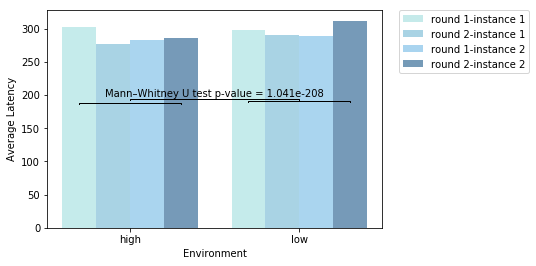

In [32]:
clrs = ['paleturquoise','skyblue', 'lightskyblue','steelblue']
box = sns.barplot(x="environment", y="average_latency", hue = 'round_instance', palette = clrs, data=graph, alpha = 0.8)
plt.xlabel('Environment')
plt.ylabel('Average Latency')
h, l = box.get_legend_handles_labels()
labels = ['round 1-instance 1', 'round 2-instance 1', 'round 1-instance 2', 'round 2-instance 2']
box.legend(h, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim(150, 300)
x1 = -0.3
x2 = 0.3
y1 = 186
y2 = 188
x3 = 0.7
x4 = 1.3
y3 = 189
y4 = 191
g1 = 0
g2 = 1
s1 = 192
s2 = 194
plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
plt.plot([x3,x3, x4, x4], [y3, y4, y4, y3], linewidth=1, color='k')
plt.plot([g1,g1, g2, g2], [s1, s2, s2, s1], linewidth=1, color='k')
plt.text((g1+g2)*.5, 195, "Mann–Whitney U test p-value = 1.041e-208", ha='center', va='bottom')
#plt.savefig('rod_fix_MWU.png', transparent = True, dpi=500)



In [33]:
low_rod_11 = data_rod_prunned[(data_rod_prunned.environment == 'low')&(data_rod_prunned.round_instance == 11)].latency
high_rod_11 = data_rod_prunned[(data_rod_prunned.environment == 'high')&(data_rod_prunned.round_instance == 11)].latency

low_rod_12 = data_rod_prunned[(data_rod_prunned.environment == 'low')&(data_rod_prunned.round_instance == 12)].latency
high_rod_12 = data_rod_prunned[(data_rod_prunned.environment == 'high')&(data_rod_prunned.round_instance == 12)].latency

low_rod_21 = data_rod_prunned[(data_rod_prunned.environment == 'low')&(data_rod_prunned.round_instance == 21)].latency
high_rod_21 = data_rod_prunned[(data_rod_prunned.environment == 'high')&(data_rod_prunned.round_instance == 21)].latency

low_rod_22 = data_rod_prunned[(data_rod_prunned.environment == 'low')&(data_rod_prunned.round_instance == 22)].latency
high_rod_22 = data_rod_prunned[(data_rod_prunned.environment == 'high')&(data_rod_prunned.round_instance == 22)].latency



In [34]:
ss.mannwhitneyu(low_rod_11, high_rod_11)

MannwhitneyuResult(statistic=520510.0, pvalue=0.05281682029550461)

In [35]:
ss.mannwhitneyu(low_rod_12, high_rod_12)

MannwhitneyuResult(statistic=511018.5, pvalue=0.0008573569470904852)

In [36]:
ss.mannwhitneyu(low_rod_22, high_rod_22)

MannwhitneyuResult(statistic=507493.5, pvalue=0.00014087875700020765)

In [37]:
ss.mannwhitneyu(low_rod_21, high_rod_21)

MannwhitneyuResult(statistic=521390.5, pvalue=0.1303089012021289)

## Maybe it is dependent on time?

In [652]:
structure = data_rod.groupby(['order', 'id', 'round_instance'])['external_id'].count().reset_index()
full_24 = structure[structure.external_id == 24]

In [653]:
full_24.head(2)

,order,id,round_instance,external_id
9,high-low,668244.000,12.000,24
16,high-low,668251.000,11.000,24


In [646]:
full_24.groupby(['date']).count()

,order,id,round_instance,external_id,trial_index,price_displayed,key pressed,environment,task,function_id,quality_check,builtin_rt,end_time,start_time,Participant Public ID,key_pressed,trial_label,latency
date,,,,,,,,,,,,,,,,,,
0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
24,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156


low -- 11,21
high -- 12, 22

In [25]:
by_trial_problem.groupby('trial_label').nunique()

,id,environment,trial_label,external_id,trial_index,price_displayed,key pressed,order,round_instance,task,function_id,quality_check,builtin_rt,end_time,start_time,Participant Public ID,key_pressed,date,latency
trial_label,,,,,,,,,,,,,,,,,,,
11.0 11.0,4,2,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
11.0 12.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
11.0 21.0,5,2,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
11.0 22.0,6,2,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
3.0 11.0,6,2,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
3.0 12.0,4,2,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4.0 21.0,4,2,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
4.0 22.0,3,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3
7.0 11.0,3,2,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


In [26]:
by_trial.trial_label.unique()

array(['11.0 12.0', '11.0 22.0', '3.0 12.0', '4.0 22.0', '7.0 12.0',
       '8.0 22.0', '11.0 11.0', '11.0 21.0', '3.0 11.0', '4.0 21.0',
       '7.0 11.0', '8.0 21.0'], dtype=object)

### Ritiwk's codes

In [23]:
da = data_useful

In [24]:
for r_instance in da['round_instance'].unique():
    da.loc[da['round_instance'] == r_instance,'latency'] = da[da['round_instance']==r_instance].groupby('id')['start_time'].diff().shift(-1)
 

In [29]:
#da['latency'].head(400)

how are you calcualting the last latency? 

# Analysis

### Discard the first spike

In [38]:
def mask_first(x):
    """
    get rid of the first spike by creating a mask of 0, 1, 1, 1, ...
    """
    result = np.ones_like(x)
    result[0] = 0
    return result

make a copy of the original data file

In [39]:
data_original = data_useful

In [40]:
mask = data_useful.groupby(['id', 'trial_label'])['trial_label'].transform(mask_first).astype(bool)
data_useful = data_useful.loc[mask]
# now we got rid of the first spike of fishing and rod fixing

In [41]:
#data_useful.head(100)

## Fishing Data

In [42]:
data_fish = data_useful[(data_useful.function_id == "fishing_l")|(data_useful.function_id == "fishing_h")]

In [43]:
len(data_fish)
320780

320780

In [44]:
data_fish['latency'].describe()

count   311164.000
mean       231.436
std       4713.519
min         79.000
25%        149.000
50%        172.000
75%        196.000
max     488425.000
Name: latency, dtype: float64

### Outliers

In [45]:
data_fish_prunned = data_fish[data_fish['id'] != 668262.0] #failed sound check
data_fish_prunned = data_fish_prunned[data_fish_prunned['id'] != 675528.0] #failed sound check
data_fish_prunned = data_fish_prunned[data_fish_prunned['id'] != 675577.0] #failed sound check
data_fish_prunned = data_fish_prunned[data_fish_prunned['id'] != 680119.0] #failed sound check
data_fish_prunned = data_fish_prunned[data_fish_prunned['id'] != 672593.0] #missing high fix
data_fish_prunned = data_fish_prunned[data_fish_prunned['id'] != 683242.0] # only tapped 7 times 
                                                                           # in the low value env 
                                                                           # -> massive outlier in the data
len(data_fish_prunned['id'].unique())

94

In [130]:
data_check = data_fish[data_fish['id'] != 668262.0] #failed sound check
data_check= data_check[data_check['id'] != 675528.0] #failed sound check
data_check = data_check[data_check['id'] != 675577.0] #failed sound check
data_check= data_check[data_check['id'] != 680119.0] #failed sound check
data_check = data_check[data_check['id'] != 672593.0] #missing high fix
data_check = data_check[data_check['id'] != 683242.0] # only tapped 7 times 

data_check = data_check[data_check['id'] != 675654.0]                              # in the low value env 
                                                                           # -> massive outlier in the data

In [47]:
len(data_check)

299348

In [48]:
data_fish_prunned['environment_binary'] = np.where(data_fish_prunned['environment']=='low', 0, data_fish_prunned['environment'])
data_fish_prunned['environment_binary'] = np.where(data_fish_prunned['environment']=='high', 1, data_fish_prunned['environment'])
data_fish_prunned['environment_binary'] = np.where(data_fish_prunned['environment']=='low', 0, data_fish_prunned['environment_binary'])
data_fish_prunned['environment_binary'] = np.where(data_fish_prunned['environment']=='high', 1, data_fish_prunned['environment_binary'])
data_fish_prunned['log_latency'] = np.log(data_fish_prunned['latency'])


In [49]:
data_fish_prunned.isnull().sum()
data_fish_prunned = data_fish_prunned[data_fish_prunned.latency.notnull()]

## Latency Outlier

In [50]:
data_fish_prunned.log_latency.describe()

count   292306.000
mean         5.164
std          0.272
min          4.369
25%          5.004
50%          5.147
75%          5.278
max          9.222
Name: log_latency, dtype: float64

MAD = Median(X\_i - X\_median)
<br>resilient to outliers

In [64]:
robust.mad(data_fish_prunned.log_latency)

0.20120283797505234

In [65]:
np.median(data_fish_prunned.log_latency)

5.147494476813453

In [66]:
5.147494476813453 + 3 * 0.20120283797505234

5.75110299073861

In [67]:
5.147494476813453 - 3 * 0.20120283797505234

4.543885962888296

In [68]:
outlier_mad = data_fish_prunned[(data_fish_prunned.log_latency > 5.75110299073861)|(data_fish_prunned.log_latency < 4.543885962888296)]
removed = data_fish_prunned[(data_fish_prunned.log_latency < 5.75110299073861)|(data_fish_prunned.log_latency > 4.543885962888296)]



In [69]:
outlier_mad.groupby('price_displayed')['log_latency'].count()

price_displayed
0.100    2530
0.300    1961
0.700    1475
1.200    1152
1.800    1142
2.500    1151
Name: log_latency, dtype: int64

The higher the price, the more outliers removed. 
<br>If we are not removing the true observations, te removed outliers should be approximately the same quantity. 

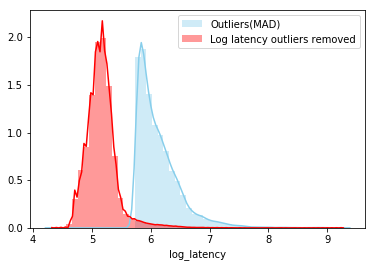

In [70]:
sns.distplot(outlier_mad["log_latency"] , color="skyblue", label="Outliers(MAD)")
sns.distplot(removed["log_latency"] , color="red", label="Log latency outliers removed")
plt.legend()

plt.show()

Standard Deviation

In [71]:
np.std(data_fish_prunned.log_latency)

0.27158278453939294

In [72]:
np.mean(data_fish_prunned.log_latency)

5.164426252579191

Because there is really big numbers in the dataset, SD is under influence.

In [73]:
5.164426252579191 + 3 * 0.27158278453939294

5.97917460619737

## Try something new
### DBSCAN

In [74]:
# Use MAD as the distance required
robust.mad(data_fish_prunned.log_latency)

0.20120283797505234

In [75]:
# Compute the minimum sample required
data_fish_prunned.groupby('price_displayed')['log_latency'].count()

price_displayed
0.100    44016
0.300    46437
0.700    48066
1.200    50350
1.800    51216
2.500    52221
Name: log_latency, dtype: int64

In [76]:
outlier_detection = data_fish_prunned[['price_displayed', 'log_latency']] 

In [61]:
from sklearn.cluster import DBSCAN

In [77]:
#clustering = DBSCAN(eps=0.20120283797505234, min_samples=1000).fit_predict(outlier_detection)

In [78]:
#clustering

In [79]:
#outlier_detection['label'] = clustering

In [80]:
#outlier_DCSCAN = outlier_detection[(outlier_detection.log_latency > 5.75110299073861)|(outlier_detection.log_latency < 4.543885962888296)]
#outlier_DCSCAN.head(100)


In [81]:
# from matplotlib import cm
# cmap = cm.get_cmap('Accent')
# outlier_detection.plot.scatter(
#   x = "price_displayed",
#   y = "log_latency",
#   c = clustering,
#   cmap = cmap,
#   colorbar = True
# )


#### Using MAD would get rid of many points
We are worried that the removing outliers by MAD will eventually results in removing the 'normal' observations from the data set. 
<br> We need a way to remove outliers by cluster.

Individual plots for 680168

In [83]:
data_fish_168 = data_fish_prunned[data_fish_prunned['id'] == 680168.0]
data_fish_168 = data_fish_168.groupby(['environment', 'price_displayed'])['latency'].mean()
data_fish_168.head(20)

environment  price_displayed
high         0.100             548.812
             0.300             351.792
             0.700             236.328
             1.200             190.670
             1.800             168.275
             2.500             155.351
low          0.100             444.312
             0.300             381.026
             0.700             353.008
             1.200             328.769
             1.800             316.329
             2.500             290.886
Name: latency, dtype: float64

In [84]:
price = [0.1, 0.3, 0.7, 1.2, 1.8, 2.5]
latency_high = [548.812, 351.792, 236.328, 190.670, 168.275, 155.351]
latency_low = [444.312, 381.026, 353.008, 328.769, 316.329, 290.886]

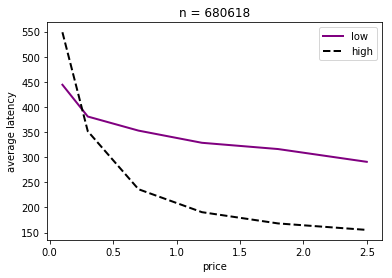

In [85]:
plt.plot( price, latency_low, marker='', color='purple', linewidth=2, label = "low")
plt.plot( price, latency_high, marker='', color='black', linewidth=2, linestyle='dashed', label="high")
plt.title("n = 680618")
plt.xlabel("price")
plt.ylabel("average latency")
plt.legend()

### Price-Latency by environment graph

In [86]:
graph = data_fish_prunned.groupby(["price_displayed", "function_id"])['latency'].mean().reset_index()
graph.columns = ['price_displayed', 'function_id', 'average_latency']



In [87]:
price = [0.1, 0.3, 0.7, 1.2, 1.8, 2.5]
latency_l = graph.average_latency[(graph.function_id == 'fishing_l')]
latency_h = graph.average_latency[(graph.function_id == 'fishing_h')]

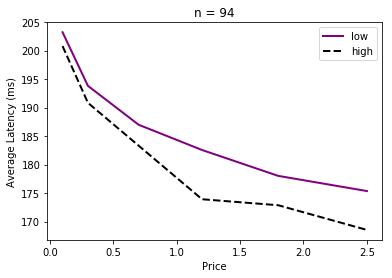

In [88]:
plt.plot( price, latency_l, marker='', color='purple', linewidth=2, label = "low")
plt.plot( price, latency_h, marker='', color='black', linewidth=2, linestyle='dashed', label="high")
plt.title("n = 93")
plt.xlabel("Price")
plt.ylabel("Average Latency (ms)")
plt.legend()
plt.savefig('price_latency.png', transparent=True, dpi=300)

## Normalization

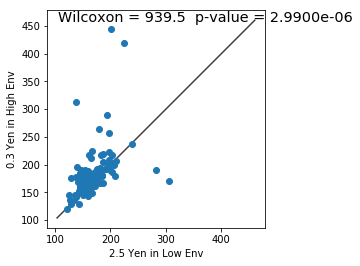

In [93]:
#For normalization, just do a scatterplot across your 100 subjects 
#of median latency 
#for the highest reward in low env vs the equivalent in high env. 
#If 2/3 are on one side of the line, it's an issue.

# Highest reward in low envrionemnt (0.5 pound worth 3000 yen) 2.5 
data_low_highest = data_fish_prunned[(data_fish_prunned.environment == 'low')&(data_fish_prunned.price_displayed == 2.5)]
low_median = data_low_highest.groupby('id')['latency'].median().reset_index(name = 'median_latency')
low_median['median_latency']
# the equivalent of 2.5 in low env is 0.3 in high environment
data_high_equal = data_fish_prunned[(data_fish_prunned.environment == 'high')&(data_fish_prunned.price_displayed == 0.3)]
high_median = data_high_equal.groupby('id')['latency'].median().reset_index(name = 'median_latency')
high_median['median_latency']

fig, ax = plt.subplots()
ax.scatter(low_median['median_latency'], high_median['median_latency'])
ax.set_xlabel('2.5 Yen in Low Env')
ax.set_ylabel('0.3 Yen in High Env')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
plt.annotate('Wilcoxon = 939.5  p-value = 2.9900e-06', xy=(0.05, 0.95), xycoords='axes fraction', size = 'x-large')
ax.plot(lims,lims, 'k-', alpha=0.75, zorder=0)
plt.savefig('normalization.png', transparent=True, dpi=300)
ax.set_aspect('equal')
# people tap faster in the low environment --> maybe there is a price effect

In [94]:
ss.wilcoxon(low_median['median_latency'], high_median['median_latency'])

WilcoxonResult(statistic=939.5, pvalue=2.9900335780128323e-06)

### Linear regression with predictor fatigue

In [51]:
data_fish_prunned['tap_count']=[1]*len(data_fish_prunned)
# fatigue per environment


In [52]:
len(data_fish_prunned) # before running tao

292306

In [53]:
tap = data_fish_prunned.groupby(['id', 'environment'])['tap_count'].cumsum().reset_index(name = 'fatigue')


In [54]:
tap = tap.reset_index().set_index('index')

In [55]:
tap = tap.drop('level_0', axis =1)

In [56]:
#tap.head(10)

In [103]:
#data_fish_prunned.head(10)

In [57]:
#tap = tap.set_index('index')
data_fish_prunned = tap.merge(data_fish_prunned, left_index = True, right_index=True,how='outer')

In [58]:
len(data_fish_prunned)

292306

In [59]:
len(data_fish_prunned.id.unique())

94

In [388]:
# to_ret = []
# for f in tap.fatigue:
#     to_ret = to_ret + [f]*f

In [389]:
#data_fish_prunned['fatigue'] = to_ret

## Linear Mixed Model

endog (1d array-like) – The dependent variable
exog (2d array-like) – A matrix of covariates used to determine the mean structure (the “fixed effects” covariates).
groups (1d array-like) – A vector of labels determining the groups – data from different groups are independent
exog_re (2d array-like) – A matrix of covariates used to determine the variance and covariance structure (the “random effects” covariates). If None, defaults to a random intercept for each group.

In [107]:
data_fish_prunned.isnull().sum()
data_fish_prunned = data_fish_prunned[data_fish_prunned.latency.notnull()]

In [108]:
len(data_fish_prunned)

292306

In [105]:
f_model = mixedlm(formula = 'log_latency ~ 1 + environment_binary + price_displayed + fatigue',
                  groups = data_fish_prunned['id'],
                  re_formula = "~environment_binary + price_displayed + fatigue",
                  data = data_fish_prunned)

r = f_model.fit(method = 'powell')

#dir(r)
#r.params

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [106]:
print (r.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           log_latency
No. Observations:             292306            Method:                       REML       
No. Groups:                   94                Scale:                        0.0486     
Min. group size:              1290              Likelihood:                   26080.1565 
Max. group size:              4443              Converged:                    Yes        
Mean group size:              3109.6                                                     
-----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      5.237    0.021 250.913 0.000  5.196  5.278
environment_binary[T.1]             

In [107]:
r_params = pd.DataFrame(r.params,columns=['LMM'])
random_effects = pd.DataFrame(r.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index=str, columns={'groups': 'LMM'})

In [108]:
random_effects.to_csv('random_effects.csv',  sep = ',', encoding='utf-8')

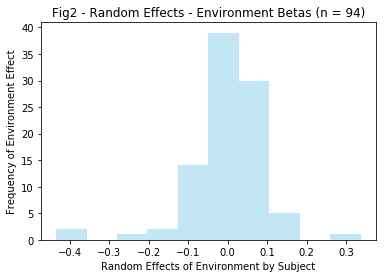

In [109]:
x = random_effects['environment_binary[T.1]']
plt.hist(x, alpha=0.5, label='x', color = 'skyblue')
plt.title('Fig2 - Random Effects - Environment Betas (n = 94)')
plt.xlabel('Random Effects of Environment by Subject')
plt.ylabel('Frequency of Environment Effect')
plt.savefig('environment_beta_29.png', transparent=True, dpi=300)

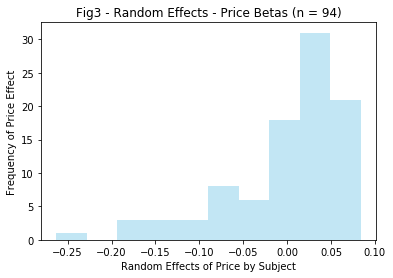

In [110]:
x = random_effects['price_displayed']
plt.hist(x, alpha=0.5, label='x', color = 'skyblue')
plt.title('Fig3 - Random Effects - Price Betas (n = 94)')
plt.xlabel('Random Effects of Price by Subject')
plt.ylabel('Frequency of Price Effect')
plt.savefig('price_beta_29.png', transparent=True, dpi=300)

## Environment Beta and tap difference

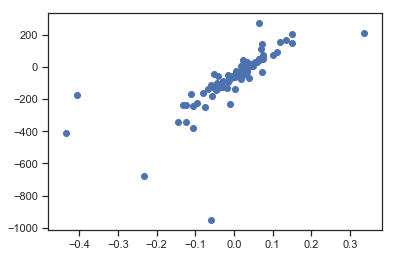

In [536]:
tap = data_fish_prunned.groupby(['id', 'environment'])['tap_count'].sum().reset_index(name = 'difference')
tap = tap.groupby(tap.index//2)['difference'].diff(-1).dropna().reset_index()

y = -1*tap['difference']
x = random_effects['environment_binary[T.1]']
plt.scatter(x, y)

# Correlation between scales and random effects

In [92]:
AMI_prunned['id']=AMI_prunned['id'].astype('str')

In [93]:
HAD_prunned['id']=HAD_prunned['id'].astype('str')

In [94]:
AMI_prunned = AMI_prunned.reset_index().set_index('id')

In [95]:
HAD_prunned = HAD_prunned.reset_index().set_index('id')

In [96]:
HAD_prunned = HAD_prunned[['anxiety', 'depression', 'tHAD']]

In [97]:
AMI_prunned = AMI_prunned[['bAMI', 'sAMI', 'eAMI', 'tAMI']]

In [111]:
correlation_table = AMI_prunned.merge(random_effects, left_index=True, right_index=True, how = 'inner')
#correlation_table = AMI_prunned.join(random_effects, how='inner')

In [112]:
correlation_table = correlation_table.merge(HAD_prunned, left_index=True, right_index=True, how='inner')

In [113]:
correlation_table.head(2)

,bAMI,sAMI,eAMI,tAMI,Group,environment_binary[T.1],price_displayed,fatigue,anxiety,depression,tHAD
id,,,,,,,,,,,
668220.0,0.167,0.667,1.167,0.667,-0.076,0.035,0.003,-0.000,0.000,0.000,0.000
668225.0,1.500,2.667,0.667,1.611,0.129,-0.124,-0.086,-0.000,7.000,5.000,12.000


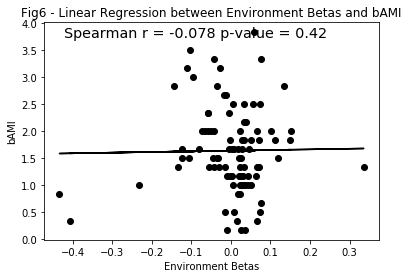

In [114]:
x = correlation_table['environment_binary[T.1]']
y = correlation_table['bAMI']

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.xlabel("Environment Betas")
plt.ylabel("bAMI")

plt.plot(x,y,'o',x,line,color = 'black')
plt.title('Fig6 - Linear Regression between Environment Betas and bAMI')
plt.annotate('Spearman r = -0.078 p-value = 0.42', xy=(0.06, 0.93), xycoords='axes fraction', size = 'x-large')

plt.savefig('bAMI.png', transparent=True, dpi=300)
#plt.scatter(x, y, linewidth=2, color='purple', linestyle='-', marker='o', label="y=x^2")

In [115]:
ss.spearmanr(x,y)

SpearmanrResult(correlation=-0.0999337651789539, pvalue=0.33789550683046543)

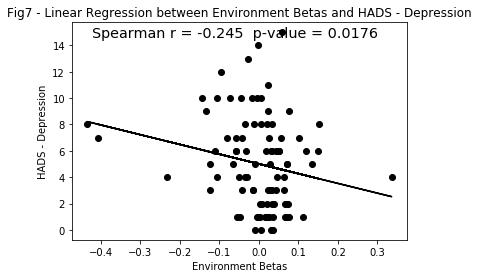

In [116]:
x = correlation_table['environment_binary[T.1]']
y = correlation_table['depression']

mask = ~np.isnan(x) & ~np.isnan(y)

slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
line = slope*x+intercept

plt.xlabel("Environment Betas")
plt.ylabel("HADS - Depression")

plt.plot(x,y,'o',x, line,color = 'black')
plt.title('Fig7 - Linear Regression between Environment Betas and HADS - Depression')
plt.annotate('Spearman r = -0.245  p-value = 0.0176', xy=(0.06, 0.93), xycoords='axes fraction', size = 'x-large')

plt.savefig('HADS_depression.png', transparent=True, dpi=300)
#plt.scatter(x, y, linewidth=2, color='purple', linestyle='-', marker='o', label="y=x^2")

In [125]:
x = correlation_table['environment_binary[T.1]']
y = correlation_table['depression']
ss.pearsonr(x[mask],y[mask])

(-0.2058593222980232, 0.04774360365787946)

In [128]:
x_env = correlation_table['environment_binary[T.1]']
x_price = random_effects['price_displayed']
y_depression = correlation_table['depression']
y_anxiety = correlation_table['anxiety']
y_had = correlation_table['tHAD']

In [129]:
ss.spearmanr(x_env[mask],y_depression[mask])

SpearmanrResult(correlation=-0.24561152677440248, pvalue=0.01764285791386034)

In [121]:
ss.spearmanr(x_env[mask],y_anxiety[mask])

SpearmanrResult(correlation=-0.15017048326574256, pvalue=0.1507843013035788)

In [122]:
ss.spearmanr(x_price[mask],y_anxiety[mask])

SpearmanrResult(correlation=-0.040453293779738754, pvalue=0.7002382531147053)

In [124]:
ss.spearmanr(x_price[mask],y_depression[mask])

SpearmanrResult(correlation=-0.028729651117201167, pvalue=0.7845703440155951)

In [134]:
demographics_corr=demographics

In [135]:
demographics_corr['id']=demographics_corr['id'].astype('str')
demographics_corr = demographics_corr.reset_index()

In [136]:
demographics_corr = demographics_corr.drop('index', axis =1).set_index('id')
demographics_corr = demographics_corr.pivot(columns='question',values='response')


In [137]:
demographics_corr.head(1)

question,nan,age-1,confirmation-1-1,confirmation-1-2,gender-1,gender-1-quantised,handedness-1,handedness-1-quantised,response-1,response-1-quantised
id,,,,,,,,,,
668220.0,NaN,43,I do not have any psychiatric or neurological ...,I am not taking any medications for psychiatri...,Male,2,Right-handed,1,Bachelor's Degree,2


In [138]:
demographics_data = demographics_corr[['age-1','gender-1']]
demographics_data.head(2)

question,age-1,gender-1
id,,
668220.0,43,Male
668225.0,31,Male


In [139]:
demographics_data['gender-1'] = np.where(demographics_data['gender-1']=='Male', 0, demographics_data['gender-1'])
demographics_data['gender-1'] = np.where(demographics_data['gender-1']=='Female', 1, demographics_data['gender-1'])


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [140]:
correlation_table = demographics_data.merge(correlation_table, right_index = True, left_index = True, how = 'inner')




In [141]:
correlation_table.isnull().sum()
correlation_table = correlation_table[correlation_table.depression.notnull()]

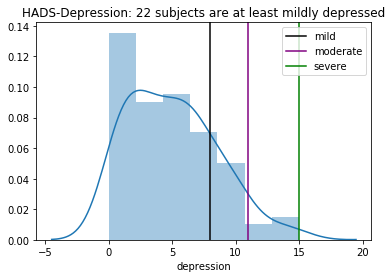

In [157]:
sns.distplot(correlation_table['depression'])
plt.axvline(x = 8, label = 'mild', color = 'black')
plt.axvline(x = 11, label = 'moderate', color = 'purple')
plt.axvline(x = 15, label = 'severe', color = 'green')
plt.title('HADS-Depression: 22 subjects are at least mildly depressed')
plt.legend()
plt.savefig('HADS-Depression.png', dpi = 300)

In [143]:
depressed = correlation_table[(correlation_table.depression > 8)|(correlation_table.depression == 8)]
len(depressed)

22

# Linear Regression for environment betas and depression

In [144]:
from sklearn.linear_model import LinearRegression

In [145]:
from sklearn import linear_model
clf = linear_model.LinearRegression()

In [146]:
x_depression_control = correlation_table[['age-1', 'gender-1', 'depression']]
y_env = correlation_table['environment_binary[T.1]']
correlation_table['env'] = correlation_table['environment_binary[T.1]']
correlation_table['age'] = correlation_table['age-1']
correlation_table['gender'] = correlation_table['gender-1']

In [147]:
clf.fit(x_depression_control, y_env)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [148]:
clf.score(x_depression_control, y_env)

0.0491948238474782

In [149]:
clf.coef_

array([ 0.00069178,  0.00431254, -0.00527055])

In [150]:
sk.feature_selection.f_regression(x_depression_control, y_env, center=True)

(array([1.15443723, 0.32988298, 4.02706262]),
 array([0.28546291, 0.5671451 , 0.0477436 ]))

## Correlation between deprpession and tap differences

In [493]:
tap_difference = data_fish_prunned.groupby(['id', 'environment'])['tap_count'].sum().reset_index(name = 'difference').set_index('id')
tap = tap_difference.groupby(tap_difference.index//2)['difference'].diff(-1).dropna().reset_index(name = 'difference')
tap['id']=tap['id'].astype('str')
tap = tap.set_index('id')



In [495]:
correlation_table = correlation_table.merge(tap, right_index = True, left_index = True, how='inner')

In [496]:
correlation_table.head(2)

,age-1,gender-1,bAMI,sAMI,eAMI,tAMI,Group,environment_binary[T.1],price_displayed,fatigue,anxiety,depression,tHAD,env,age,gender,difference
id,,,,,,,,,,,,,,,,,
668220.0,43,0,0.167,0.667,1.167,0.667,-0.076,0.035,0.003,-0.000,0.000,0.000,0.000,0.035,43,0,26.000
668225.0,31,0,1.500,2.667,0.667,1.611,0.129,-0.124,-0.086,-0.000,7.000,5.000,12.000,-0.124,31,0,342.000


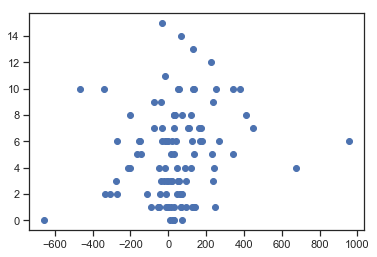

In [497]:
plt.scatter(correlation_table['difference'], correlation_table['depression'])

In [498]:
ss.spearmanr(correlation_table['difference'], correlation_table['depression'])

SpearmanrResult(correlation=0.18932581096974355, pvalue=0.05192751431881574)

### Price-Latency Plot by subject and environment

In [223]:
fish_subject = data_fish_prunned.groupby(["id","price_displayed", "environment"])['latency'].mean().reset_index()
fish_subject.columns = ['id','price_displayed', 'environment', 'average_latency']

(120, 350)

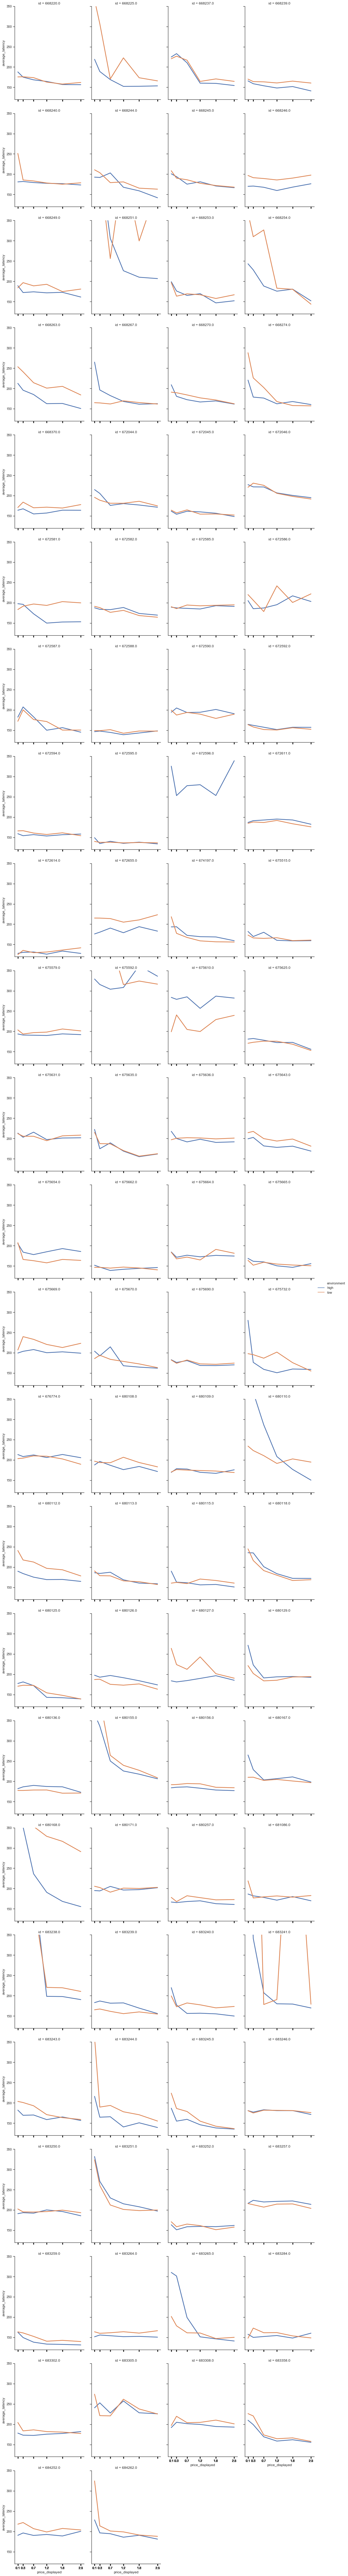

In [224]:
sns.set(style="ticks")
by_subject = sns.relplot(x="price_displayed", y="average_latency", hue="environment", 
            col="id", col_wrap=4,legend = 'full',
            height=5, aspect=.75, linewidth=2.5,
            kind="line",data=fish_subject)
by_subject.set(xticks= fish_subject["price_displayed"])
plt.ylim([120,350])

In [225]:
by_subject.savefig("output120_350.png")

In [226]:
len(data_fish.id.unique())

100

In [269]:
data_fish.to_csv('fish_100.csv', sep = ',', encoding='utf-8')

## Rod Fixing Data

In [228]:
data_rod = data_original[(data_original.function_id == "rod_fixing")]

### Check if everyone tap at least once within the 13000 msecs

In [229]:
data_rod[data_rod.quality_check == 0]

,external_id,trial_index,id,price_displayed,key pressed,environment,order,round_instance,task,function_id,quality_check,builtin_rt,end_time,start_time,Participant Public ID,key_pressed,date,trial_label,latency
index,,,,,,,,,,,,,,,,,,,
62338,5be376b6a0e7750001a053a4,3.000,672596.000,0.700,39.000,high,high-low,11.000,rod_fixing,rod_fixing,0.000,17825.500,1554832873330.000,1554832855504.000,5be376b6a0e7750001a053a4,39.000,09/04/2019 17:01:04,3.0 11.0,17829.000
62551,5be376b6a0e7750001a053a4,7.000,672596.000,0.100,39.000,high,high-low,11.000,rod_fixing,rod_fixing,0.000,115515.745,1554833032422.000,1554832916905.000,5be376b6a0e7750001a053a4,39.000,09/04/2019 17:03:43,7.0 11.0,nan
348152,5bda1da4d6fef5000181aab2,8.000,675669.000,1.800,39.000,low,low-high,21.000,rod_fixing,rod_fixing,0.000,20676.015,1555086572813.000,1555086552136.000,5bda1da4d6fef5000181aab2,39.000,12/04/2019 16:09:19,8.0 21.0,nan
349485,5bda1da4d6fef5000181aab2,4.000,675669.000,1.800,39.000,high,low-high,22.000,rod_fixing,rod_fixing,0.000,28883.955,1555086893052.000,1555086864167.000,5bda1da4d6fef5000181aab2,39.000,12/04/2019 15:57:33,4.0 22.0,nan


### Check if anyone taps more than 8 times

In [230]:
by_trial_hier = data_rod.groupby(['id', 'environment', 'trial_label']).count().reset_index()
by_trial_hier['index'] = by_trial_hier[['id', 'trial_label']].apply(lambda x: ' '.join(x.astype(str)), axis=1)
by_trial_hier = by_trial_hier.set_index('index')

In [231]:
bytrial_latency = data_rod.groupby(['id', 'environment', 'trial_label'])['latency'].sum().reset_index(name = 'sum_latency')
bytrial_latency['index'] = bytrial_latency[['id', 'trial_label']].apply(lambda x: ' '.join(x.astype(str)), axis=1)
bytrial_latency = bytrial_latency.set_index('index')
by_trial_rod = pd.merge(by_trial_hier, bytrial_latency, left_index=True, right_index=True)


In [232]:
by_trial_rod = by_trial_rod[['id_x', 'environment_x', 'trial_label_x', 'trial_index', 'sum_latency', 'key_pressed']]
by_trial_rod.columns = ['id','environment','trial_label', 'trial_index','sum_latency', 'key_pressed']


In [233]:
by_trial_rod_problem_1 = by_trial_rod[(by_trial_rod['key_pressed'] > 8)]
by_trial_rod_problem_1.id.unique()

array([668270., 672593., 675577., 675654., 680115., 680171.])

now go back to using data_useful (no first spike)

In [234]:
data_rod = data_useful[(data_useful.function_id == "rod_fixing")]

In [235]:
data_rod.to_csv('rod_100_no_first_spike.csv', sep = ',', encoding='utf-8')

## Spearman Rank-order Correlation Coefficient -- Online

In [81]:
high_o = data_fish[(data_fish['environment'] == 'high')]
high_o_spearman_r = high_o.groupby('id')[['price_displayed', 'latency']].corr(method = 'spearman')
high_o_spearman_r = high_o_spearman_r['price_displayed'].reset_index(name = 'r')
high_o_spearman_r = high_o_spearman_r[high_o_spearman_r.r != 1][['id', 'r']]
high_o_spearman_r.head(3)

,id,r
1,668220.000,-0.565
3,668225.000,-0.402
5,668237.000,-0.610


In [82]:
low_o = data_fish[(data_fish['environment'] == 'low')]
low_o_spearman_r = low_o.groupby('id')[['price_displayed', 'latency']].corr(method = 'spearman')
low_o_spearman_r = low_o_spearman_r['price_displayed'].reset_index(name = 'r')
low_o_spearman_r = low_o_spearman_r[low_o_spearman_r.r != 1][['id', 'r']]
low_o_spearman_r.head(3)

,id,r
1,668220.000,-0.421
3,668225.000,-0.358
5,668237.000,-0.551


# Spearman Rank-order Correlation Coefficient -- In-lab

In [78]:
# import in-lab data and convert to panda dataframe
mat = sio.loadmat('untransformeddataforRN.mat', squeeze_me=True)
m = mat['untransformed_data']
in_lab = pd.DataFrame(m)
in_lab.columns = ['latency', 'price_displayed', 
             'id', 'price_bin', 'apathy', 'environment_binary']
in_lab.head(3)

,latency,price_displayed,id,price_bin,apathy,environment_binary
0,128.000,1.200,1.000,4.000,12.000,1.000
1,110.000,1.200,1.000,4.000,12.000,1.000
2,110.000,1.200,1.000,4.000,12.000,1.000


In [86]:
high_i = in_lab[(in_lab['environment_binary'] == 1)]
high_i_spearman_r = high_i.groupby('id')[['price_displayed', 'latency']].corr(method = 'spearman')
high_i_spearman_r = high_i_spearman_r['price_displayed'].reset_index(name = 'r')
high_i_spearman_r = high_i_spearman_r[high_i_spearman_r.r != 1][['id', 'r']]
high_i_spearman_r.head(3)

,id,r
1,1.000,-0.413
3,2.000,-0.170
5,3.000,-0.593


In [87]:
low_i = in_lab[(in_lab['environment_binary'] == 0)]
low_i_spearman_r = low_i.groupby('id')[['price_displayed', 'latency']].corr(method = 'spearman')
low_i_spearman_r = low_i_spearman_r['price_displayed'].reset_index(name = 'r')
low_i_spearman_r = low_i_spearman_r[low_i_spearman_r.r != 1][['id', 'r']]
low_i_spearman_r.head(3)

,id,r
1,1.000,-0.269
3,2.000,-0.356
5,3.000,-0.516


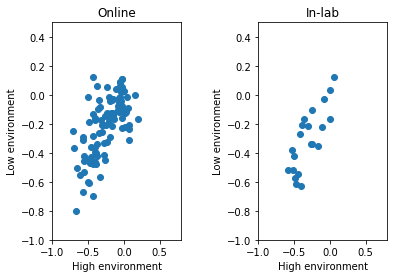

In [88]:
plt.subplot(1, 2, 1)
plt.scatter(high_o_spearman_r['r'], low_o_spearman_r['r'])
plt.title('Online')
plt.xlabel('High environment')
plt.ylabel('Low environment')
plt.xlim(-1, 0.8)
plt.ylim(-1, 0.5)
plt.subplot(1, 2, 2)
plt.scatter(high_i_spearman_r['r'], low_i_spearman_r['r'])
plt.title('In-lab')
plt.xlabel('High environment')
plt.ylabel('Low environment')
plt.xlim(-1, 0.8)
plt.ylim(-1, 0.5)
plt.subplots_adjust(wspace = 0.6)

# Questionnaires

In [66]:
def extract_choice(ser):
    choice = []
    for s in ser:
        c = 0
        while c < len(s):
            r = json.loads(s[c])
            for key in r.keys():
                choice.append(r[key])
            c = c + 1
    return choice

## AMI

In [67]:
# import AMI
AMI = pd.read_csv('data_exp_6138-v39_task-j8g3.csv', sep = ",")
#AMI

In [68]:
AMI_group = AMI.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
# response = AMI_group['choice made'][0]
choice = extract_choice(AMI_group['choice made'])
AMI_group = AMI_group.loc[AMI_group.index.repeat(19)] #repeat no of questions times

In [69]:
AMI_group['choice'] = choice
AMI_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]*100

In [70]:
AMI_group.choice[AMI_group.choice == "Completely UNTRUE"] = 4
AMI_group.choice[AMI_group.choice == "Mostly untrue"] = 3
AMI_group.choice[AMI_group.choice == "Neither true nor untrue"] = 2
AMI_group.choice[AMI_group.choice == "Quite true"] = 1
AMI_group.choice[AMI_group.choice == "Completely TRUE"] = 0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

In [71]:
# by taking the mean rating of the items within the subscale.
# bAMI = questions [5 9 10 11 12 16]
# sAMI = questions [2 3 4  8  15 18]
# eAMI = questions [1 6 7  14 17 19]
# trick_question = 13
# tAMI = sum
bAMI = AMI_group[(AMI_group.question_number == 5)|(AMI_group.question_number == 9)|(AMI_group.question_number == 10)|(AMI_group.question_number == 11)|(AMI_group.question_number == 12)|(AMI_group.question_number == 16)]
sAMI = AMI_group[(AMI_group.question_number == 2)|(AMI_group.question_number == 3)|(AMI_group.question_number == 4)|(AMI_group.question_number == 8)|(AMI_group.question_number == 15)|(AMI_group.question_number == 18)]
eAMI = AMI_group[(AMI_group.question_number == 1)|(AMI_group.question_number == 6)|(AMI_group.question_number == 7)|(AMI_group.question_number == 14)|(AMI_group.question_number == 17)|(AMI_group.question_number == 19)]
trick_AMI = AMI_group[(AMI_group.question_number == 13)]
bAMI = bAMI.groupby(['Participant Private ID'])['choice'].sum().reset_index()
bAMI.columns = ['id', 'bAMI']
bAMI['score'] = bAMI['bAMI']/6
sAMI = sAMI.groupby(['Participant Private ID'])['choice'].sum().reset_index()
sAMI.columns = ['id', 'sAMI']
sAMI['score'] = sAMI['sAMI']/6
eAMI = eAMI.groupby(['Participant Private ID'])['choice'].sum().reset_index()
eAMI.columns = ['id', 'eAMI']
eAMI['score'] = eAMI['eAMI']/6
AMI_final = {'id': bAMI['id'], 'bAMI': bAMI['score'], 'sAMI': sAMI['score'], 'eAMI': eAMI['score']}
AMI_final = pd.DataFrame(data=AMI_final)
AMI_final['tAMI'] = (bAMI['score'] + sAMI['score'] + eAMI['score'])/3

In [72]:
AMI_prunned = AMI_final[AMI_final['id'] != 668262.0] #failed sound check
AMI_prunned = AMI_prunned[AMI_prunned['id'] != 675528.0] #failed sound check
AMI_prunned = AMI_prunned[AMI_prunned['id'] != 675577.0] #failed sound check
AMI_prunned = AMI_prunned[AMI_prunned['id'] != 680119.0] #failed sound check
AMI_prunned = AMI_prunned[AMI_prunned['id'] != 672593.0] #missing high fix
AMI_prunned = AMI_prunned[AMI_prunned['id'] != 683242.0] # only tapped 7 times 
                                                                           # in the low value env 
                                                                           # -> massive outlier in the data

In [73]:
(AMI_prunned['bAMI']*6).describe()

count   94.000
mean     9.819
std      4.754
min      1.000
25%      7.000
50%      9.000
75%     12.000
max     23.000
Name: bAMI, dtype: float64

In [74]:
9.819 +4.754

14.573

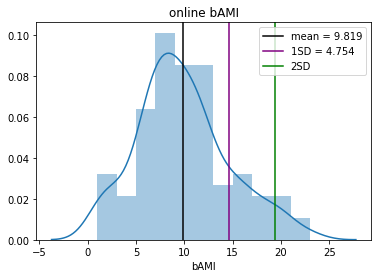

In [151]:
sns.distplot(AMI_prunned['bAMI']*6)
plt.title('online bAMI')
plt.axvline(x = 9.819, color = 'black', label = 'mean = 9.819')
plt.axvline(x = 14.573, color = 'purple', label = '1SD = 4.754')
plt.axvline(x = 19.327, color = 'green', label = '2SD')
plt.legend(loc = 1)
plt.savefig('online_bAMI.png', dpi = 300)

In [79]:
in_lab_AMI = in_lab.groupby('id')['apathy'].unique().reset_index(name = 'bAMI')
b = []
for a in in_lab_AMI['bAMI']:
    b.append(a[0])
in_lab_AMI['bAMI'] = b

In [80]:
in_lab_AMI['bAMI'].describe()

count   21.000
mean     9.810
std      5.288
min      1.000
25%      6.000
50%      9.000
75%     13.000
max     21.000
Name: bAMI, dtype: float64

In [81]:
9.810 + 5.288*2

20.386000000000003

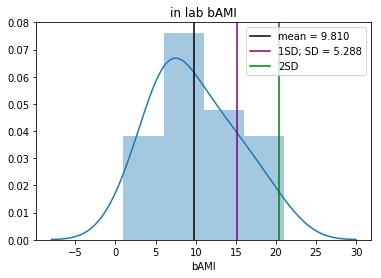

In [152]:
sns.distplot(in_lab_AMI['bAMI'])
plt.title('in lab bAMI')
plt.axvline(x = 9.810, color = 'black', label = 'mean = 9.810')
plt.axvline(x = 15.098, color = 'purple', label = '1SD; SD = 5.288')
plt.axvline(x = 20.386, color = 'green', label = '2SD')
plt.legend(loc = 1)
plt.savefig('inlab_bAMI.png', dpi = 300)

In [140]:
AMI_final.to_csv('AMI_100.csv', sep = ',', encoding='utf-8')

## HAD

### add 668245 to the dataset as nan

In [83]:
# import HAD
HAD = pd.read_csv('data_exp_6138-v39_task-w8es.csv', sep = ",")
HAD.drop(HAD.tail(1).index,inplace=True)
HAD = HAD[HAD['Participant Private ID'] != 668245] # twice

In [84]:
HAD_group = HAD.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice = extract_choice(HAD_group['choice made'])
HAD_group = HAD_group.loc[HAD_group.index.repeat(15)]


In [85]:
len(HAD_group["Participant Private ID"].unique())

99

In [86]:
HAD_group['choice'] = choice
HAD_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]*99

In [87]:
# question 12 is the trick question
HAD_group['scale'] = [{"Most of the time" : 3, "A lot of the time": 2, "From time to time, occasionally" : 1, "Not at all":0},
                      {"Nearly all the time": 3, "Very often": 2, "Sometimes": 1, "Not at all":0},
                      {"Definitely as much":0, "Not quite so much":1, "Only a little":2, "Hardly at all":3},
                      {"Not at all":0, "Occasionally":1, "Quite Often":2, "Very Often":3},
                      {"Very definitely and quite badly":3, "Yes, but not too badly":2, "A little, but it doesn't worry me":1, "Not at all":0},
                      {"Definitely":3, "I don't take as much care as I should":2,"I may not take quite as much care":1, "I take just as much care as ever":0},
                      {"As much as I always could":0, "Not quite so much now":1, "Definitely not so much now":2, "Not at all":3},
                      {"Very much indeed":3, "Quite a lot":2,"Not very much":1, "Not at all":0},
                      {"A great deal of the time":3, "A lot of the time":2, "From time to time, but not too often":1,"Only occasionally":0},
                      {"As much as I ever did":0, "Rather less than I used to":1, "Definitely less than I used to":2, "Hardly at all":3},
                      {"Not at all":3, "Not often":2,"Sometimes":1, "Most of the time":0},
                      {"Not at all":3, "Not often":2,"Sometimes":1, "Most of the time":0},
                      {"Very often indeed":3, "Quite often":2,"Not very often":1, "Not at all":0},
                      {"Definitely":0, "Usually":1, "Not Often":2,"Not at all":3},
                      {"Often":0, "Sometimes":1,"Not often":2, "Very seldom":3}]*99

In [88]:
# 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,    13, 14, 15
# A, D, D, A, A, D, D, A, A, D,   D,  trick, A,  A, D

# anxiety =  [1, 4, 5, 8, 9, 13, 14]
# depression = [2, 3, 6, 7, 10, 11, 15]

value = []
for index, row in HAD_group.iterrows():
    d = row["scale"]
    k = row['choice']
    value.append(d[k])
HAD_group['value'] = value

depression = HAD_group[(HAD_group.question_number == 2)|(HAD_group.question_number == 3)|(HAD_group.question_number == 6)|(HAD_group.question_number == 7)|(HAD_group.question_number == 10)|(HAD_group.question_number == 11)|(HAD_group.question_number == 15)]
anxiety = HAD_group[(HAD_group.question_number == 1)|(HAD_group.question_number == 4)|(HAD_group.question_number == 5)|(HAD_group.question_number == 8)|(HAD_group.question_number == 9)|(HAD_group.question_number == 13)|(HAD_group.question_number == 14)]
trick = HAD_group[(HAD_group.question_number == 12)]

In [89]:
depression = depression.groupby(['Participant Private ID'])['value'].sum().reset_index()
depression.columns = ['id', 'depression']
anxiety = anxiety.groupby(['Participant Private ID'])['value'].sum().reset_index()
anxiety.columns = ['id', 'anxiety']
#HAD_group.head(5)

In [90]:
HAD_final = {'id': anxiety['id'], 'anxiety': anxiety['anxiety'], 'depression': depression['depression']}
HAD_final = pd.DataFrame(data=HAD_final)
HAD_final['tHAD'] = anxiety['anxiety'] + depression['depression']
HAD_final.loc[-1] = [668245, np.nan, np.nan,  np.nan]

HAD_final.to_csv('HAD_100.csv', sep = ',', encoding='utf-8')

In [91]:
HAD_prunned = HAD_final[HAD_final['id'] != 668262.0] #failed sound check
HAD_prunned = HAD_prunned[HAD_prunned['id'] != 675528.0] #failed sound check
HAD_prunned = HAD_prunned[HAD_prunned['id'] != 675577.0] #failed sound check
HAD_prunned = HAD_prunned[HAD_prunned['id'] != 680119.0] #failed sound check
HAD_prunned = HAD_prunned[HAD_prunned['id'] != 672593.0] #missing high fix
HAD_prunned = HAD_prunned[HAD_prunned['id'] != 683242.0] # only tapped 7 times 
                                                                           # in the low value env 
                                                                           # -> massive outlier in the data

## Baratt

In [568]:
# import Baratt
barrat = pd.read_csv('data_exp_6138-v39_task-df75.csv', sep = ",")
barrat.drop(barrat.tail(1).index,inplace=True)

In [569]:
barrat_group = barrat.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice = extract_choice(barrat_group['choice made'])
barrat_group = barrat_group.loc[barrat_group.index.repeat(31)]

In [570]:
barrat_group['choice'] = choice
barrat_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                                  19, 20, 21,22, 23, 24, 25, 26, 27, 28, 29, 30, 31]*100

In [571]:
reverse_barrat = barrat_group[barrat_group['question_number'].isin([9, 21,31, 1, 7, 8, 13, 14, 10, 16, 30])]
reverse_barrat.choice[reverse_barrat.choice == "Rarely/Never"] = 4
reverse_barrat.choice[reverse_barrat.choice == "Occasionally"] = 3
reverse_barrat.choice[reverse_barrat.choice == "Often"] = 2
reverse_barrat.choice[reverse_barrat.choice == "Almost always/Always"] = 1

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

In [572]:
# trick question
trick_barrat = barrat_group[barrat_group['question_number']==12]

In [573]:
barrat_group = barrat_group[barrat_group['question_number'].isin([5,11,29, 6, 25, 27, 2, 3, 4, 18, 20, 23, 26, 17, 22, 24,15, 19, 29])]
barrat_group.choice[barrat_group.choice == "Rarely/Never"] = 1
barrat_group.choice[barrat_group.choice == "Occasionally"] = 2
barrat_group.choice[barrat_group.choice == "Often"] = 3
barrat_group.choice[barrat_group.choice == "Almost always/Always"] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pand

### Check if standard barrat and reverse barrat are negatively correlated

In [110]:
standard_barrat = barrat_group

In [111]:
barrat_group.head(10)

,Participant Private ID,choice made,choice,question_number
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",2,2
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",3,3
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",4,4
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",1,5
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",1,6
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",1,11
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",1,15
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",1,17
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",2,18
0,668220.000,"[{""Q0"":""Often"",""Q1"":""Occasionally"",""Q2"":""Often...",1,19


### Calculate impulsivity score

In [112]:
barrat_group = pd.concat([barrat_group,reverse_barrat,trick_barrat])

In [113]:
# trick 12

# attentional =  [5, 9*, 11, 21*, 29, 6, 25, 27]
# attention = [5, 9*, 11, 21*, 29]
# Cognitive Instability = [6, 25, 27]
# motor = [2, 3, 4, 18, 20, 23, 26, 17, 22, 24, 31*]
# Motor = [2, 3, 4, 18, 20, 23, 26]
# Perseverance = [17, 22, 24, 31*]
# Nonplanning = [1*, 7*, 8*, 13*, 14*, 15, 10*, 16*, 19, 29, 30*]
# Self-Control = [1*, 7*, 8*, 13*, 14*, 15]
# Cognitive Complexity = [10*, 16*, 19, 28, 30*]
attention = barrat_group[(barrat_group.question_number == 5)|(barrat_group.question_number == 9)|(barrat_group.question_number == 11)|(barrat_group.question_number == 21)|(barrat_group.question_number == 29)]
cognitive_instable = barrat_group[(barrat_group.question_number == 6)|(barrat_group.question_number == 25)|(barrat_group.question_number == 27)]
motor = barrat_group[(barrat_group.question_number == 2)|(barrat_group.question_number == 3)|(barrat_group.question_number == 4)|(barrat_group.question_number == 18)|
                     (barrat_group.question_number == 20)|(barrat_group.question_number == 23)|(barrat_group.question_number == 26)]
perseverance = barrat_group[(barrat_group.question_number == 17)|(barrat_group .question_number == 22)|(barrat_group.question_number == 24)|(barrat_group.question_number == 31)]
self_control = barrat_group[(barrat_group.question_number == 1)|(barrat_group.question_number == 7)|(barrat_group.question_number == 8)|(barrat_group.question_number == 13)|(barrat_group.question_number == 14)|(barrat_group.question_number == 15)]
cognitive_complexity = barrat_group[(barrat_group.question_number == 10)|(barrat_group.question_number == 16)|(barrat_group.question_number == 19)|(barrat_group.question_number == 28)|(barrat_group.question_number == 30)]
trick = barrat_group[barrat_group.question_number == 12]



In [114]:
#trick
#668249, 672614, 675732, 672593

In [115]:
attention = attention.groupby(['Participant Private ID'])['choice'].sum().reset_index()
attention.columns = ['id', 'attention']
cognitive_instable = cognitive_instable.groupby(['Participant Private ID'])['choice'].sum().reset_index()
cognitive_instable.columns = ['id', 'cognitive_instable']
motor = motor.groupby(['Participant Private ID'])['choice'].sum().reset_index()
motor.columns = ['id', 'motor']
perseverance = perseverance.groupby(['Participant Private ID'])['choice'].sum().reset_index()
perseverance.columns = ['id', 'perseverance']
self_control = self_control.groupby(['Participant Private ID'])['choice'].sum().reset_index()
self_control.columns = ['id', 'self_control']
cognitive_complexity = cognitive_complexity.groupby(['Participant Private ID'])['choice'].sum().reset_index()
cognitive_complexity.columns = ['id', 'cognitive_complexity']

In [116]:
barrat_final = {'id': attention['id'], 'attention': attention['attention'], 
                'cognitive_instable': cognitive_instable['cognitive_instable'],
               'motor': motor['motor'],
               'perseverance': perseverance['perseverance'],
               'self_control': self_control['self_control'],
               'cognitive_complexity': cognitive_complexity['cognitive_complexity']}
barrat_final = pd.DataFrame(data=barrat_final)
barrat_final['attentional'] = attention['attention'] + cognitive_instable['cognitive_instable']
barrat_final['motor_0'] = motor['motor'] + perseverance['perseverance']
barrat_final['nonplanning'] = self_control['self_control'] + cognitive_complexity['cognitive_complexity']
barrat_final['total'] = barrat_final['attentional'] + barrat_final['motor_0'] + barrat_final['nonplanning']


In [117]:
barrat_final.to_csv('barrat_100.csv', sep = ',', encoding='utf-8')

# Correlation between scales

## Apathy and Impulsivity

The higher the score, the more impulsive/apathetic you are.
<br>Apathy and impulsive relationship remains unknown in healthy population.
For patients with Parkinson, we know there is an overlap between apathy and impulsivity

In [118]:
barrat_final.head(3)

,id,attention,cognitive_instable,motor,perseverance,self_control,cognitive_complexity,attentional,motor_0,nonplanning,total
0,668220.000,6,4,16,8,9,8,10,24,17,51
1,668225.000,9,5,14,7,14,6,14,21,20,55
2,668237.000,13,6,16,5,10,13,19,21,23,63


In [119]:
AMI_final.head(3)

,id,bAMI,sAMI,eAMI,tAMI
0,668220.000,0.167,0.667,1.167,0.667
1,668225.000,1.500,2.667,0.667,1.611
2,668237.000,1.667,2.000,1.000,1.556


In [122]:
ss.spearmanr(barrat_final['total'], AMI_final['tAMI'])

SpearmanrResult(correlation=0.205389039647476, pvalue=0.040366590824304306)

In [123]:
ss.spearmanr(barrat_final['attentional'], AMI_final['bAMI'])

SpearmanrResult(correlation=0.3521848130423103, pvalue=0.00032636954296588625)

In [124]:
ss.spearmanr(barrat_final['motor_0'], AMI_final['bAMI'])

SpearmanrResult(correlation=-0.030842347672190584, pvalue=0.7606568746134115)

In [125]:
ss.spearmanr(barrat_final['attentional'], AMI_final['sAMI'])

SpearmanrResult(correlation=0.20854943530614278, pvalue=0.03732161312429298)

In [126]:
ss.spearmanr(barrat_final['nonplanning'], AMI_final['sAMI'])

SpearmanrResult(correlation=0.28255942647673643, pvalue=0.004394580951191723)

### Pleasure and HADS
The higher you score on pleasure scale, the less pleasure you perceive

In [143]:
ss.spearmanr(HAD_final['tHAD'], pleasure_final['total'], nan_policy='omit')

SpearmanrResult(correlation=0.13972847469861607, pvalue=0.1677711047493032)

### Pleasure and Apathy

In [197]:
ss.spearmanr(AMI_final['tAMI'], pleasure_final['total'], nan_policy='omit')

SpearmanrResult(correlation=0.5099657259427548, pvalue=5.978141408569172e-08)

### Pleasure and Fatigue

In [199]:
ss.spearmanr(fatigue_final['total'], pleasure_final['total'], nan_policy='omit')

SpearmanrResult(correlation=0.4512390693535458, pvalue=2.4558027277339126e-06)

### Fatigue and Pleasure

In [200]:
ss.spearmanr(fatigue_final['total'], pleasure_final['total'], nan_policy='omit')

SpearmanrResult(correlation=0.4512390693535458, pvalue=2.4558027277339126e-06)

### HADS and Apathy

In [201]:
ss.spearmanr(HAD_final['tHAD'], AMI_final['tAMI'], nan_policy='omit')

SpearmanrResult(correlation=0.009954433832335107, pvalue=0.9220991451326828)

### Pleasure and Impulsivity

In [203]:
ss.spearmanr(pleasure_final['total'], barrat_final['total'], nan_policy='omit')
# the more impulsive you are, the less pleasure you perceive

SpearmanrResult(correlation=0.20134212324789394, pvalue=0.0445659150663093)

## Pleasure

In [128]:
# import pleasure
pleasure = pd.read_csv('data_exp_6138-v39_task-uvof.csv', sep = ",")
pleasure.drop(pleasure.tail(1).index,inplace=True)

In [129]:
pleasure_group = pleasure.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice = extract_choice(pleasure_group['choice made'])
pleasure_group = pleasure_group.loc[pleasure_group.index.repeat(15)]

In [130]:
pleasure_group['choice'] = choice
pleasure_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]*100

In [131]:
# Definitely Agree (= 1)
# Agree (= 2)
# Disagree (= 3)
# Definitely Disagree (= 4)
pleasure_group.choice[pleasure_group.choice == "Strongly agree"] = 1
pleasure_group.choice[pleasure_group.choice == "Agree"] = 2
pleasure_group.choice[pleasure_group.choice == "Disagree"] = 3
pleasure_group.choice[pleasure_group.choice == "Strongly disagree"] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/Frameworks/Python.

In [132]:
trick = pleasure_group[pleasure_group.question_number == 8]
#trick.head(100)

In [133]:
pleasure_final = {'id': pleasure_group['Participant Private ID']}
pleasure_final = pd.DataFrame(data=pleasure_final)
p = pleasure_group.groupby('Participant Private ID')['choice'].sum().reset_index(name = 'total')
pleasure_final['total'] = p['total']
pleasure_final=pleasure_final.drop_duplicates()
len(pleasure_final)

100

In [134]:
pleasure_final.head(200)

,id,total
0,668220.000,18
1,668225.000,30
2,668237.000,22
3,668239.000,32
4,668240.000,28
5,668244.000,26
6,668245.000,28
7,668246.000,28
8,668249.000,17
9,668251.000,21


In [135]:
pleasure_final.to_csv('pleasure_100.csv', sep = ',', encoding='utf-8')

## Fatigue

In [136]:
# import fatigue
fatigue = pd.read_csv('data_exp_6138-v39_task-j95b.csv', sep = ",")
fatigue.drop(fatigue.tail(1).index,inplace=True)

In [137]:
fatigue_group = fatigue.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice_fatigue= extract_choice(fatigue_group['choice made'])
fatigue_group = fatigue_group.loc[fatigue_group.index.repeat(22)]

In [138]:
fatigue_group['choice'] = choice_fatigue
fatigue_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                                  19, 20, 21,22]*100

In [139]:
# 'Never', 'Rarely', 'Sometimes', 'Often', 'Almost always'
#   0         1          2            3           4
fatigue_group.choice[fatigue_group.choice == "Never"] = 0
fatigue_group.choice[fatigue_group.choice == "Rarely"] = 1
fatigue_group.choice[fatigue_group.choice == "Sometimes"] = 2
fatigue_group.choice[fatigue_group.choice == "Often"] = 3
fatigue_group.choice[fatigue_group.choice == "Almost always"] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pand

In [140]:
# trick question 5
# Physical 4, 7, 8, 11, 14, 15, 18, 21, 22
# Cognitive 1, 2, 3, 6, 12, 13, 16, 17, 19, 20
# Psychosocial 9, 10

fatigue_physical = fatigue_group[fatigue_group['question_number'].isin([4, 7, 8, 11, 14, 15, 18, 21, 22])]
fatigue_cognitive = fatigue_group[fatigue_group['question_number'].isin([1, 2, 3, 6, 12, 13, 16, 17, 19, 20])]
fatigue_psychological = fatigue_group[fatigue_group['question_number'].isin([9, 10])]
fatigue_trick = fatigue_group[fatigue_group['question_number'].isin([5])]

In [141]:
physical = fatigue_physical.groupby(['Participant Private ID'])['choice'].sum().reset_index()
physical.columns = ['id', 'physical']
cognitive = fatigue_cognitive.groupby(['Participant Private ID'])['choice'].sum().reset_index()
cognitive.columns = ['id', 'cognitive']
psychological = fatigue_psychological.groupby(['Participant Private ID'])['choice'].sum().reset_index()
psychological.columns = ['id', 'psychological']

In [142]:
fatigue_final = {'id': physical['id'], 'physical': physical['physical'], 
                'cognitive': cognitive['cognitive'],
               'psychological': psychological['psychological']}
fatigue_final = pd.DataFrame(data=fatigue_final)
fatigue_final['total'] = fatigue_final['physical'] + fatigue_final['cognitive'] + fatigue_final['psychological']

fatigue_final.to_csv('fatigue_100.csv', sep = ',', encoding='utf-8')

## Bonus

In [285]:
bonus = data.sort_values('date').groupby(["external_id","price_displayed", "function_id"]).size()
bonus = bonus.reset_index()
bonus.columns = ['id', 'price_displayed', 'factor', 'tap']
bonus = bonus.replace('fishing_h', 4/3000)
bonus = bonus.replace('fishing_l', 0.5/3000)
bonus = bonus.replace('rod_fixing', 0)
bonus.head(10)

,id,price_displayed,factor,tap
0,55b9a9b0fdf99b6906d2aba4,0.100,0.001,246
1,55b9a9b0fdf99b6906d2aba4,0.100,0.000,232
2,55b9a9b0fdf99b6906d2aba4,0.100,0.000,32
3,55b9a9b0fdf99b6906d2aba4,0.300,0.001,259
4,55b9a9b0fdf99b6906d2aba4,0.300,0.000,256
5,55b9a9b0fdf99b6906d2aba4,0.300,0.000,15
6,55b9a9b0fdf99b6906d2aba4,0.700,0.001,259
7,55b9a9b0fdf99b6906d2aba4,0.700,0.000,255
8,55b9a9b0fdf99b6906d2aba4,0.700,0.000,16
9,55b9a9b0fdf99b6906d2aba4,1.200,0.001,249


In [286]:
bonus = bonus.round(20)
bonus['earning'] = bonus['price_displayed']*bonus['factor']*bonus['tap']
pay = bonus.groupby(['id'])['earning'].sum().reset_index()
pay['earning'] = np.ceil(pay['earning'])
pay['prolific'] = [','.join(i) for i in zip(pay["id"].map(str),pay["earning"].astype(str))]
pay
pay.to_csv('prolific_bonus.csv', sep = ',', encoding='utf-8')

In [544]:
correlation_table.head(1)

,age-1,gender-1,bAMI,sAMI,eAMI,tAMI,Group,environment_binary[T.1],price_displayed,fatigue,anxiety,depression,tHAD,env,age,gender,difference
id,,,,,,,,,,,,,,,,,
668220.0,43,0,0.167,0.667,1.167,0.667,-0.076,0.035,0.003,-0.000,0.000,0.000,0.000,0.035,43,0,26.000
